In [157]:
#----------------------------------------------------------------------------------------------------------------------------
#Main imports
#----------------------------------------------------------------------------------------------------------------------------
from tqdm import tqdm_notebook
from datetime import timedelta
from IPython.display import display,Markdown
import pandas as pd
import numpy as np
import numba
#----------------------------------------------------------------------------------------------------------------------------
#Charting
#----------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
%matplotlib inline
#----------------------------------------------------------------------------------------------------------------------------
#LOGGING
#----------------------------------------------------------------------------------------------------------------------------
import logging
logging.basicConfig(handlers=[logging.FileHandler('app.log'),logging.StreamHandler()], format='%(asctime)s - %(levelname)s - %(filename)s - %(name)s - %(funcName)s - line: %(lineno)d - %(message)s',level=logging.INFO)
#----------------------------------------------------------------------------------------------------------------------------
#Inits
#----------------------------------------------------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

### Fide ratings

In [2]:
blitz_players=pd.read_fwf('blitz_rating_list.zip')

In [3]:
blitz_players.head()

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,DEC19,Gms,K,B-day,Flag
0,10207538,"A E M, Doshtagir",BAN,M,NaN,NaN,NaN,NaN,1860,0,20.0,1974,i
1,5716373,"A Rajah, Abdul Shukor",MAS,M,NaN,NaN,NaN,NaN,1873,0,20.0,0000,NaN
2,4804929,"A-ALI,Sali Abbas Abdulzahra",IRQ,F,WFM,WFM,NaN,NaN,1730,0,20.0,2001,wi
3,5700230,"A.B, Muhd Yusop",MAS,M,NaN,NaN,NaN,NaN,1528,0,20.0,1983,i
4,10202650,"A.k. Azad, Akand",BAN,M,NaN,NaN,NaN,NaN,1731,0,20.0,0000,i


In [137]:
blitz_players.sort_values('DEC19',ascending=False).head(10)

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,DEC19,Gms,K,B-day,Flag
80901,2016192,"Nakamura, Hikaru",USA,M,GM,NaN,NaN,NaN,2885,18,20.0,1987,NaN
19024,1503014,"Carlsen, Magnus",NOR,M,GM,NaN,NaN,NaN,2865,18,20.0,1990,NaN
54043,14109603,"Karjakin, Sergey",RUS,M,GM,NaN,NaN,NaN,2836,18,20.0,1990,NaN
27755,8603677,"Ding, Liren",CHN,M,GM,NaN,NaN,NaN,2830,18,20.0,1992,NaN
108597,14108836,"Shkuro, Iuri",UKR,M,GM,NaN,NaN,NaN,2828,0,20.0,1982,i
82115,4168119,"Nepomniachtchi, Ian",RUS,M,GM,NaN,NaN,NaN,2826,18,20.0,1990,NaN
111424,5202213,"So, Wesley",USA,M,GM,NaN,NaN,NaN,2816,36,20.0,1993,NaN
129274,8603820,"Yu, Yangyi",CHN,M,GM,NaN,NaN,NaN,2807,0,20.0,1994,NaN
115537,4102142,"Svidler, Peter",RUS,M,GM,NaN,NaN,NaN,2805,0,20.0,1976,NaN
54476,4100018,"Kasparov, Garry",RUS,M,GM,NaN,NaN,NaN,2801,0,20.0,1963,i


In [4]:
import requests,grequests
headers={'accept-encoding': 'gzip, deflate','accept-language': 'en-US,en;q=0.9', 'user-agent': 'Mozilla','accept': 'application/json, text/javascript, */*',
         'X-Requested-With': 'XMLHttpRequest',
                'Referer': 'https://ratings.fide.com',
                'Cookie':''}

In [9]:
big_list=[]
n_processed=0
errored_urls=[]
nparallel_downloads=3
urls_to_process=[('https://ratings.fide.com/a_chart_data.phtml?event=%s&period=0' % id) for id in blitz_players['ID Number'].astype(str).values] #[:100]['34105414','4153472']'
rs = (grequests.get(sub_url,verify=True,headers=headers,allow_redirects=True) for sub_url in urls_to_process) 
logging.info('Started crawling fide profiles! nlinks=%d' % (len(urls_to_process)))
pbar=tqdm_notebook(urls_to_process)
for resp,(sub_url) in zip(grequests.imap(rs, size=nparallel_downloads),urls_to_process):
    n_processed=n_processed+1
    if len(resp.history)>0:
        final_status_code=resp.history[-1].status_code
    else:
        final_status_code=resp.status_code
    if not (resp is None):
        if resp.status_code==200:
            try:
                ReportBody=resp.json()
                big_list.extend(ReportBody)
            except Exception as e:
                errored_urls.append(sub_url)
                logging.error('Error extracting json from url %s: %s' % (sub_url,e))
        else:
            errored_urls.append(sub_url)
            logging.error('Error for url %s: status_code=%s' % (sub_url,final_status_code))
    else:
        errored_urls.append(sub_url)
        logging.error('Resp is None for url %s' % sub_url)  
    if (n_processed % 10) ==0:
        pbar.update(10)
logging.info('Finished! n_processed=%d,n_errored=%d' % (n_processed,len(errored_urls)))
df=pd.DataFrame(big_list)
pbar.close()

2019-12-15 07:59:59,318 - INFO - <ipython-input-9-ea1bb88181d4> - root - <module> - line: 9 - Started crawling fide profiles! nlinks=132364


2019-12-15 08:38:47,930 - ERROR - <ipython-input-9-ea1bb88181d4> - root - <module> - line: 27 - Error for url https://ratings.fide.com/a_chart_data.phtml?event=2111187&period=0: status_code=502
2019-12-15 08:41:48,019 - ERROR - <ipython-input-9-ea1bb88181d4> - root - <module> - line: 27 - Error for url https://ratings.fide.com/a_chart_data.phtml?event=12800694&period=0: status_code=502
2019-12-15 08:42:08,019 - ERROR - <ipython-input-9-ea1bb88181d4> - root - <module> - line: 27 - Error for url https://ratings.fide.com/a_chart_data.phtml?event=9954589&period=0: status_code=502
2019-12-15 08:53:28,484 - ERROR - <ipython-input-9-ea1bb88181d4> - root - <module> - line: 27 - Error for url https://ratings.fide.com/a_chart_data.phtml?event=3980731&period=0: status_code=502
2019-12-15 08:56:39,050 - ERROR - <ipython-input-9-ea1bb88181d4> - root - <module> - line: 27 - Error for url https://ratings.fide.com/a_chart_data.phtml?event=32005083&period=0: status_code=502
2019-12-15 08:56:39,050 - ER

In [64]:
df.set_index('name',inplace=True)
df.rename(columns={'date_2':'date'},inplace=True)
df.date=pd.to_datetime(df.date)
for field in 'rating,period_games,rapid_rtng,rapid_games,blitz_rtng,blitz_games'.split(','):
    df[field]=df[field].astype(np.float32)
df.to_pickle('blitz_ratings_dynamic.zip')

C:\ProgramData\Anaconda3\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [5]:
df=pd.read_pickle('blitz_ratings_dynamic.zip')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8985435 entries, A E M, Doshtagir to Zywert, Kacper
Data columns (total 9 columns):
id_number       object
date            datetime64[ns]
rating          float32
period_games    float32
rapid_rtng      float32
rapid_games     float32
blitz_rtng      float32
blitz_games     float32
country         object
dtypes: datetime64[ns](1), float32(6), object(2)
memory usage: 479.9+ MB


In [9]:
#Who's the daddy?
for discipline in ['rating','rapid_rtng','blitz_rtng']:
    print(discipline.upper()+' CHAMPION:')
    display(df[df[discipline]==df[discipline].max()])

RATING CHAMPION:


,id_number,date,rating,period_games,rapid_rtng,rapid_games,blitz_rtng,blitz_games,country
name,,,,,,,,,
"Carlsen, Magnus",1503014,2014-05-01,2882.0,1.0,2827.0,0.0,2837.0,0.0,NOR
"Carlsen, Magnus",1503014,2019-08-01,2882.0,11.0,2895.0,0.0,2920.0,0.0,NOR


RAPID_RTNG CHAMPION:


,id_number,date,rating,period_games,rapid_rtng,rapid_games,blitz_rtng,blitz_games,country
name,,,,,,,,,
"Carlsen, Magnus",1503014,2017-07-01,2822.0,9.0,2919.0,11.0,2899.0,27.0,NOR


BLITZ_RTNG CHAMPION:


,id_number,date,rating,period_games,rapid_rtng,rapid_games,blitz_rtng,blitz_games,country
name,,,,,,,,,
"Carlsen, Magnus",1503014,2017-12-01,2837.0,0.0,2908.0,9.0,2986.0,16.0,NOR


In [43]:
@numba.njit()
def running_max(x):
    rmax=x[0]
    y=np.empty_like(x)
    for i,val in enumerate(x):
        if val>rmax: rmax=val
        y[i]=rmax
    return y
@numba.njit()
def compute_stats(rtng):    
    rtng=rtng[~np.isnan(rtng)]
    if len(rtng)>0:
        cummax_rtng=running_max(rtng)

        max_abs_cons_growth=(rtng[1:]-rtng[:-1]).max()
        max_perc_cons_growth=((rtng[1:]-rtng[:-1])/rtng[:-1]).max()

        max_abs_cum_growth=(rtng[1:]-cummax_rtng[:-1]).max()
        max_perc_cum_growth=((rtng[1:]-cummax_rtng[:-1])/cummax_rtng[:-1]).max()    
        return max_abs_cons_growth,max_perc_cons_growth,max_abs_cum_growth,max_perc_cum_growth
    else:
        return np.nan,np.nan,np.nan,np.nan
def show_payer_performance(name,discipline='blitz_rtng'):
    player=df[df.index==name].reset_index()
    ax=player.plot(x='date',y=['rating','rapid_rtng','blitz_rtng'],marker='o',figsize=(15,10),title=name+', id '+player['id_number'].dropna().unique()[0]);    
    rtng=player[discipline].values
    max_abs_cons_growth,max_perc_cons_growth,max_abs_cum_growth,max_perc_cum_growth=compute_stats(rtng)
    stats='СТАТИСТИКА %s\n\nМакс. абс. посл. рост: %.0f\nМакс. проц. посл. рост: %.0f%%\nМакс. абс. кум. рост: %.0f\nМакс. проц. кум. рост: %.0f%%' % (discipline,max_abs_cons_growth,max_perc_cons_growth*100,max_abs_cum_growth,max_perc_cum_growth*100)    
    ax.text(player.date.max()-timedelta(days=120), player[['rating','rapid_rtng','blitz_rtng']].min().min(), stats, style='italic', horizontalalignment='right', verticalalignment='bottom',bbox={ 'facecolor':'wheat', 'alpha':0.5, 'pad':5})    

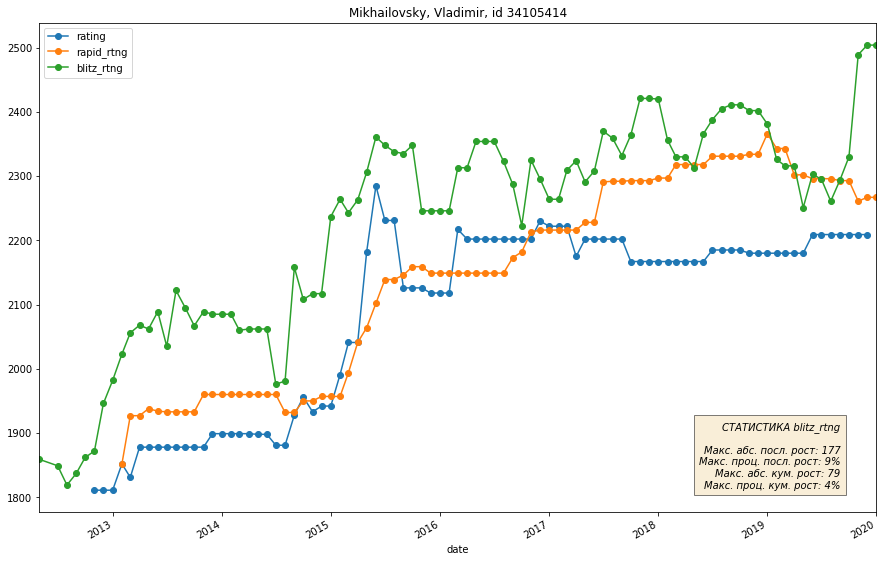

In [45]:
show_payer_performance('Mikhailovsky, Vladimir')

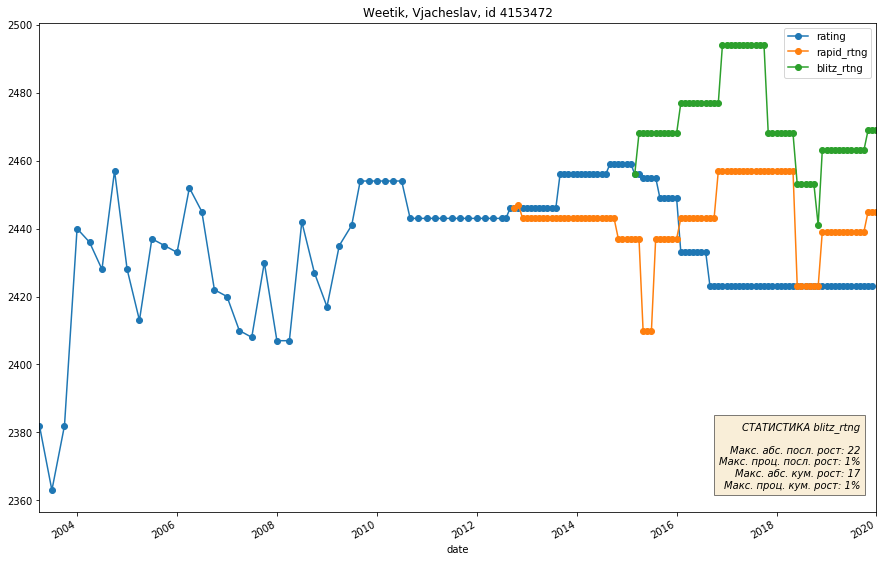

In [46]:
show_payer_performance('Weetik, Vjacheslav')

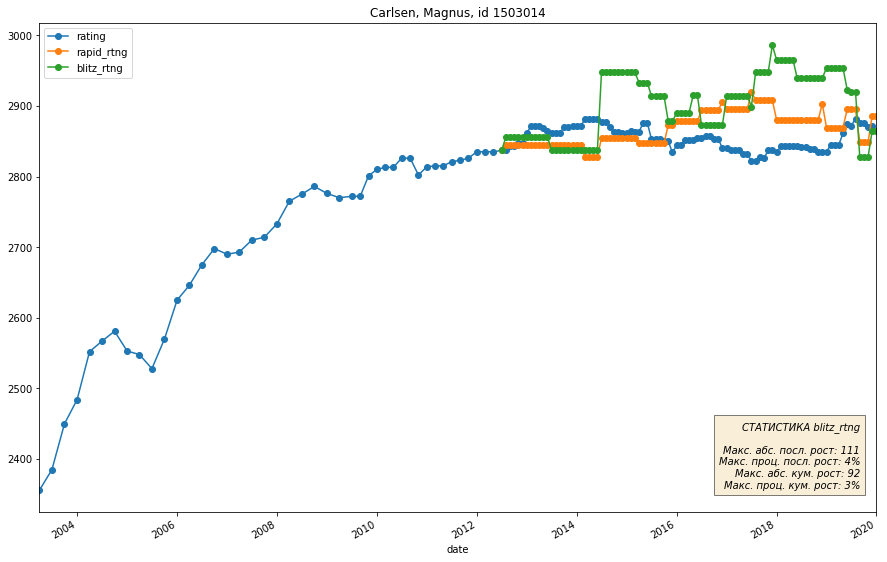

In [91]:
show_payer_performance('Carlsen, Magnus')

#### Compute growth stats of all players

In [54]:
@numba.njit()
def get_stats(ids,ratings):

    stats=[]
    last_id=0;last_i=0
    for i,theid in enumerate(ids):
        if theid!=last_id or i==len(ids)-1:
            #push data if ready
            if i>last_i  or i==len(ids)-1:
                rtng=ratings[last_i:i]
                max_abs_cons_growth,max_perc_cons_growth,max_abs_cum_growth,max_perc_cum_growth=compute_stats(rtng)
                stats.append([last_id,max_abs_cons_growth,max_perc_cons_growth,max_abs_cum_growth,max_perc_cum_growth])
            last_id=theid;last_i=i
        
    return stats
    
discipline='blitz_rtng'
ids=df['id_number'].values;ratings=df[discipline].values
idx=~pd.isnull(ids);ratings=ratings[idx];ids=ids[idx].astype(np.int64)  
stats=pd.DataFrame(get_stats(ids,ratings),columns='id,max_abs_cons_growth,max_perc_cons_growth,max_abs_cum_growth,max_perc_cum_growth'.split(','))

In [55]:
stats.id=stats.id.astype(np.int64)
stats.head()

,id,max_abs_cons_growth,max_perc_cons_growth,max_abs_cum_growth,max_perc_cum_growth
0,10207538,0.0,0.000000,-4.0,-0.002146
1,5716373,27.0,0.014626,27.0,0.014626
2,4804929,38.0,0.022592,36.0,0.021700
3,10202650,39.0,0.023050,39.0,0.023050
4,5700230,0.0,0.000000,0.0,0.000000


In [56]:
stats[stats.id==34105414]

,id,max_abs_cons_growth,max_perc_cons_growth,max_abs_cum_growth,max_perc_cum_growth
75543,34105414,177.0,0.089349,79.0,0.03953


#### How many players have absolute/percentwise consecutive/cumulative growth same or higher than our player of interest, and what are the names of top 10 most powerful of such?

In [141]:
highest_blitz_ratings=df[['id_number','blitz_rtng']].groupby('id_number').max()
highest_blitz_ratings=highest_blitz_ratings[~pd.isna(highest_blitz_ratings.blitz_rtng)]
highest_blitz_ratings.head()

,blitz_rtng
id_number,
10000097,1741.0
10000100,2301.0
1000012,2593.0
10000127,2307.0
10000186,2124.0


In [179]:
def find_sharp_players(compare_with,thresh=0.01):
    base_stats=stats[stats.id==compare_with]
    base_data=blitz_players[blitz_players['ID Number']==compare_with]
    if len(base_data)>0:
        if len(base_stats)>0:
            display(Markdown("**Comparing 'sharpest growth' performance of %s playes with player id=%s [%s]:**" % ('{:,}'.format(len(blitz_players)-1).replace(',', ' '),compare_with,base_data.Name.values[0])))
            display(base_data)
            max_rating=highest_blitz_ratings.loc[str(compare_with)].blitz_rtng
            top_pos=len(highest_blitz_ratings[highest_blitz_ratings.blitz_rtng>max_rating])
            display(Markdown("**This player had highest rating of %d and was in top %d [top %.2f%%]\n**" % (max_rating,top_pos, top_pos/len(highest_blitz_ratings)*100)))
            for metric in 'max_abs_cons_growth,max_perc_cons_growth,max_abs_cum_growth,max_perc_cum_growth'.split(','):
                base_val=base_stats[metric].values[0]
                players=stats[stats[metric]>=base_val]
                perc=len(players)/len(stats)
                if perc<thresh:
                    print("%s: %s, ONLY %.2f%% [%d players] have it same or higher, top 10 are:" % (metric.upper(),round(base_val,3), perc*100,len(players)))
                    display(blitz_players[blitz_players['ID Number'].isin(players.id.values)].sort_values('DEC19',ascending=False).head(10))
                else:
                    print("%s: %s, %.2f%% [%d players] have it same or higher" % (metric.upper(),round(base_val,3), perc*100,len(players)))

In [180]:
find_sharp_players(compare_with=34105414)

**Comparing 'sharpest growth' performance of 132 363 playes with player id=34105414 [Mikhailovsky, Vladimir]:**

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,DEC19,Gms,K,B-day,Flag
75565,34105414,"Mikhailovsky, Vladimir",RUS,M,CM,NaN,NaN,NaN,2504,4,20.0,1999,NaN


**This player had highest rating of 2504 and was in top 1136 [top 0.86%]
**

MAX_ABS_CONS_GROWTH: 177.0, ONLY 0.29% [380 players] have it same or higher, top 10 are:


,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,DEC19,Gms,K,B-day,Flag
27755,8603677,"Ding, Liren",CHN,M,GM,NaN,NaN,NaN,2830,18,20.0,1992,NaN
5366,4158814,"Andreikin, Dmitry",RUS,M,GM,NaN,NaN,NaN,2780,0,20.0,1990,NaN
68952,12539929,"Maghsoodloo, Parham",IRI,M,GM,NaN,NaN,NaN,2735,0,20.0,2000,NaN
82779,25092340,Nihal Sarin,IND,M,GM,NaN,NaN,NaN,2685,0,20.0,2004,NaN
40016,24176729,"Golubov, Saveliy",RUS,M,IM,NaN,NaN,NaN,2582,11,20.0,2000,NaN
63455,1038257,"Lai, Hing Ting",NED,M,IM,NaN,NaN,NaN,2571,0,20.0,1997,NaN
126806,1048104,"Warmerdam, Max",NED,M,IM,NaN,NaN,NaN,2537,0,20.0,2000,NaN
125578,12908088,"Vogel, Roven",GER,M,IM,NaN,NaN,NaN,2516,0,20.0,2000,NaN
98155,12904392,"Riehle, Marco",GER,M,FM,NaN,NaN,NaN,2505,0,20.0,1999,NaN
75565,34105414,"Mikhailovsky, Vladimir",RUS,M,CM,NaN,NaN,NaN,2504,4,20.0,1999,NaN


MAX_PERC_CONS_GROWTH: 0.089, ONLY 0.84% [1117 players] have it same or higher, top 10 are:


,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,DEC19,Gms,K,B-day,Flag
68952,12539929,"Maghsoodloo, Parham",IRI,M,GM,NaN,NaN,NaN,2735,0,20.0,2000,NaN
82779,25092340,Nihal Sarin,IND,M,GM,NaN,NaN,NaN,2685,0,20.0,2004,NaN
63455,1038257,"Lai, Hing Ting",NED,M,IM,NaN,NaN,NaN,2571,0,20.0,1997,NaN
126806,1048104,"Warmerdam, Max",NED,M,IM,NaN,NaN,NaN,2537,0,20.0,2000,NaN
125578,12908088,"Vogel, Roven",GER,M,IM,NaN,NaN,NaN,2516,0,20.0,2000,NaN
98155,12904392,"Riehle, Marco",GER,M,FM,NaN,NaN,NaN,2505,0,20.0,1999,NaN
75565,34105414,"Mikhailovsky, Vladimir",RUS,M,CM,NaN,NaN,NaN,2504,4,20.0,1999,NaN
66506,14531534,"Livaic, Leon",CRO,M,IM,NaN,NaN,NaN,2500,22,20.0,2000,NaN
126142,1048333,"Vrolijk, Liam",NED,M,IM,NaN,NaN,NaN,2499,0,20.0,2002,NaN
108197,14129574,"Shevchenko, Kirill",UKR,M,GM,NaN,NaN,NaN,2499,0,20.0,2002,NaN


MAX_ABS_CUM_GROWTH: 79.0, 4.38% [5796 players] have it same or higher
MAX_PERC_CUM_GROWTH: 0.04, 7.38% [9765 players] have it same or higher


In [177]:
find_sharp_players(compare_with=4153472)

**Comparing 'sharpest growth' performance of 132 363 playes with player id=4153472 [Weetik, Vjacheslav]:**

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,DEC19,Gms,K,B-day,Flag
127007,4153472,"Weetik, Vjacheslav",RUS,M,FM,NaN,NaN,NaN,2469,0,20.0,1985,NaN


**This player had highest rating of 2494 and was in top 1245 [top 0.94%]
**

MAX_ABS_CONS_GROWTH: 22.0, 34.18% [45229 players] have it same or higher
MAX_PERC_CONS_GROWTH: 0.009, 39.71% [52550 players] have it same or higher
MAX_ABS_CUM_GROWTH: 17.0, 30.63% [40531 players] have it same or higher
MAX_PERC_CUM_GROWTH: 0.007, 34.77% [46014 players] have it same or higher


In [178]:
find_sharp_players(compare_with=1503014)

**Comparing 'sharpest growth' performance of 132 363 playes with player id=1503014 [Carlsen, Magnus]:**

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,DEC19,Gms,K,B-day,Flag
19024,1503014,"Carlsen, Magnus",NOR,M,GM,NaN,NaN,NaN,2865,18,20.0,1990,NaN


**This player had highest rating of 2986 and was in top 0 [top 0.00%]
**

MAX_ABS_CONS_GROWTH: 111.0, 2.00% [2643 players] have it same or higher
MAX_PERC_CONS_GROWTH: 0.039, 9.74% [12893 players] have it same or higher
MAX_ABS_CUM_GROWTH: 92.0, 2.84% [3754 players] have it same or higher
MAX_PERC_CUM_GROWTH: 0.032, 10.69% [14143 players] have it same or higher
